## CSE 6040 extra credit project

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import copy

In [2]:
random.seed(10)

## Context
For consumer companies, understanding consumer behavior is crucial for crafting the right offers and tailoring marketing efforts to maximize reach, engagement, and sales. This dataset provides ample information to segment customers into clusters for more efficient targeting. It includes various attributes such as customer demographics, products, sales, the impact of promotions, and purchasing paths.
Data source: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data

## Analysis goal
The main objective of this analysis is to cluster customers.
Additionally, we will attempt to answer others interesting questions:
- What is the profile of the ideal customer for the company?
- Which segment is more likely to engage with the following campaigns?
- What are the most efficient channel to display offers for different segments?

### structure
1. Importing the dataset
2. Explorative analysis
3. Preprocessing
4. Modelling
5. Analyzing the results
6. Summary

** IMPORTANT NOTE**  
It is possible that the k means algorithm doesnt converge imidiately because of randomized clusters initialization since I have only done 5 runs to avoid the notebook running for too long. It took me a couple of runs to see convergence and understand why is normal that the results varies each time. I provided more explanations and a way around it at the end of the modelling section.

## 1. Importing the dataset

In [3]:
path = '/Users/newuser/visual_code/CSE_6040_extra_credit/marketing_campaign.csv'
df = pd.read_csv(path, delimiter='\t')
print('Shape of the data:', df.shape)

Shape of the data: (2240, 29)


## 2. Explorative analysis
In this section we will look at the data in different perspectives to assess its quality and deal with any inconsistency we may find prior to pre-processing. This includes checking data types, duplicates, null values outliers, Distribution and correlation.  
The outcome is a cleaned dataset stored as 'cleaned_df'.

### 2.1 Exploring data types, duplicates and null values

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [5]:
#Checking data types, duplicates and NaN values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

All columns seems to be of the right type at the exception of 'Dt_customer' is the date of customer's enrollment with the company. As such it should be of datetime value instead of object. Also Incomes seems to have some missing values.

In [6]:
# checking the proportion of null values rows in the data
pct_null_income = round(df['Income'].isnull().sum() /len(df)*100)
print('the proportion of null values of Income is {}%'.format(pct_null_income ))

the proportion of null values of Income is 1%


Since the proportion is low, we will simply drop those duplicates. Below we will take a look at unique values across all columns.

In [7]:
# Getting unique values for each column
df.nunique()

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

In [8]:
#Checking the unique values of columns with only a single unique value
df.Z_CostContact.unique(), df.Z_Revenue.unique()

(array([3]), array([11]))

The columns Z_CostContact and Z_Revenue have a single value which mean they are not meaningful for our analyis. We will drop them. Same as 'ID' which doesnt store any information.
Below we will explore the unique values of categorical columns: 'Marital_Status' and 'Education'.

In [9]:
# Checking unique values in the categorical columns
    #Marital_status
print(df.Marital_Status.unique())
df.groupby(by= 'Marital_Status').size()/len(df)*100

['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


Marital_Status
Absurd       0.089286
Alone        0.133929
Divorced    10.357143
Married     38.571429
Single      21.428571
Together    25.892857
Widow        3.437500
YOLO         0.089286
dtype: float64

In [10]:
    # Education 
print(df.Education.unique())
df.groupby(by= 'Education').size()/len(df)*100

['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


Education
2n Cycle       9.062500
Basic          2.410714
Graduation    50.312500
Master        16.517857
PhD           21.696429
dtype: float64

Marital_status: YOLO is an acronym for "You Only Live Once". It's a modern version of the Latin phrase "Carpe diem", which means "Seize the day". We will drop its row as well as Absurb. Together they represent less than 1% of the data.  
Besides, 'Single' and 'Alone' should be a single category   
Education: No issue found.

#### 2.1.1 Cleaning the data 
we will perform the cleaning tasks highlighted above:  
1- Extracting features from 'Dt_Customer'
    - 'Year_Enrollment': The year each customer was enrolled. Months and days might be too granular for this analysis.
    - 'Age_started': how old customers were when they got enrolled with the company. This could be more meaningful than the Year of birth alone.
2- Remove nan (24 rows from the column 'Income')  
3- Drop useless columns 'Z_Revenue', 'Z_CostContact'  
4- Remove irrelevant values for 'Marital_Status':  'Absurd', 'YOLO' and merge 'Single' and 'Alone' as a single category.
5- Rename the column 'Response'. It is a binary feature that says if customer accepted the offer in the last campaign or not. We will rename it to 'AcceptedCmp_last' to be consistent with the naming of campaigns.

The cleaned dataframe will be stored as 'cleaned_df'

In [11]:
# First lets make a copy of the df
cleaned_df = df.copy()

# 1- Extracting the year of enrollment from 'Dt_Customer' 
cleaned_df['Year_Enrollment'] = df['Dt_Customer'].str.extract(r'(\d{4})').astype('int') #.rename(columns= {0:'Year'}) 

# Extracting the age of each customer at their enrollment with the company
cleaned_df['Age_started'] = cleaned_df['Year_Enrollment'] - df['Year_Birth']

# Dropping the 'Dt_Customer' column after extracting all features
cleaned_df = cleaned_df.drop('Dt_Customer', axis= 1)

# 2- Remove nan (24 rows from the column 'Income') 
cleaned_df.dropna(axis= 0, inplace= True)

# 3- Drop useless columns 'Z_Revenue', 'Z_CostContact' and 'ID' which is just data indices
cleaned_df = cleaned_df.drop(['Z_Revenue', 'Z_CostContact', 'ID'], axis= 1)

# 4a- Remove irrelevant values for 'Marital_Status':  'Absurd', 'YOLO' 
mask1 = cleaned_df['Marital_Status']!= 'Absurd'
mask2 = cleaned_df['Marital_Status']!= 'YOLO'
cleaned_df = cleaned_df[mask1&mask2]

# 4b- Merge 'Single' and 'Alone' as a single category
cleaned_df.loc[cleaned_df['Marital_Status'] == 'Alone', 'Marital_Status'] = 'Single'
# 5- Rename the column 'Response'
cleaned_df = cleaned_df.rename(columns= {'Response':'AcceptedCmp_last'})


print('initial shape:', df.shape)
print('cleaned data shape:', cleaned_df.shape)
print('Updated marital status categories:',cleaned_df.Marital_Status.unique())

initial shape: (2240, 29)
cleaned data shape: (2212, 27)
Updated marital status categories: ['Single' 'Together' 'Married' 'Divorced' 'Widow']


### 2.2 Exploring outliers
Outliers can negatively impact the performance of distance based algoritms in general and  K Means is particularly sensitive to outliers which can disproportionately influence the positions of the clusters centroids.  
We will look at outliers for variables with wide range of unique values (min of 10) as they are the most likely to have outliers.

In [12]:
# Creating a mask to filter columns with wide range of unique values
outliers = cleaned_df.nunique() > 20
outliers[outliers == True]

Year_Birth          True
Income              True
Recency             True
MntWines            True
MntFruits           True
MntMeatProducts     True
MntFishProducts     True
MntSweetProducts    True
MntGoldProds        True
Age_started         True
dtype: bool

In [13]:
# Splitting outliers columns in different category for better scalling of the boxplot 
products = cleaned_df[['MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds']]
# purchases = cleaned_df[['NumDealsPurchases', 'NumWebPurchases',
#        'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']]

income= cleaned_df[['Income']]
       
years= cleaned_df[['Year_Birth', 'Age_started',  'Recency']]

<Axes: >

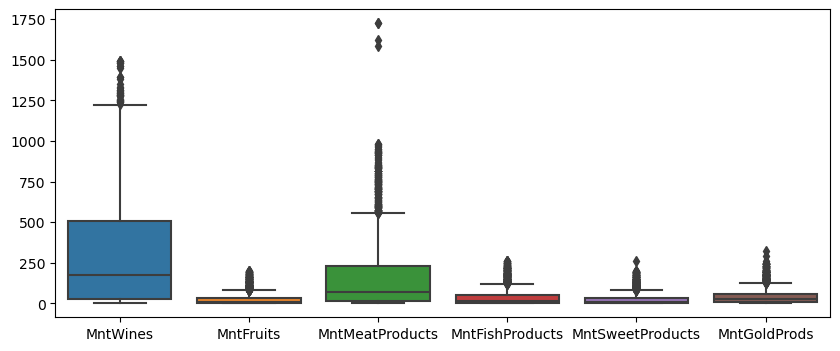

In [14]:
# outliers: products
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data= products)

<Axes: xlabel='Income'>

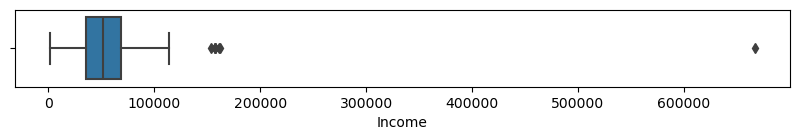

In [15]:
# outliers: Income
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(x= income['Income'])

<Axes: xlabel='Year_Birth'>

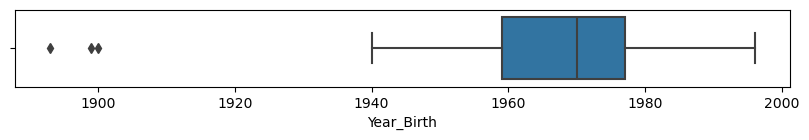

In [16]:
# outliers Year_Birith
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(x= years['Year_Birth'])

<Axes: xlabel='Age_started'>

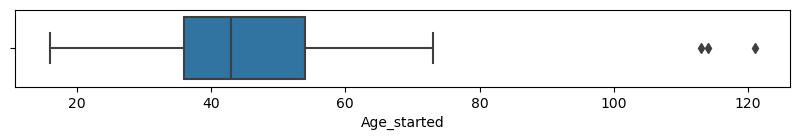

In [17]:
# outliers Age_Started
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(x= years['Age_started'])

<Axes: xlabel='Recency'>

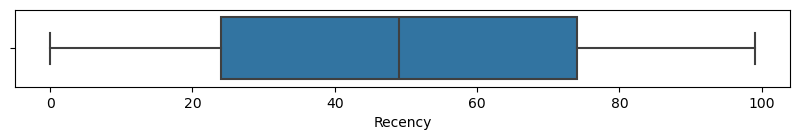

In [18]:
# outliers Year_Birith
fig, ax = plt.subplots(figsize=(10, 1))
sns.boxplot(x= years['Recency'])

We notice some extreme values (> 1600) in the products category affectinig mostly meat products. We also have outliers within the column 'Income' around a threshold of 100,000 and 'Year_Birth' around the year 1940. we will trim the data using those values as limit.  
No outliers found in Recency.

#### 2.2.1 Removing outliers

In [19]:
# Removing outliers
mask_product = cleaned_df['MntMeatProducts'] <= 1600 
mask_income = cleaned_df['Income'] <= 100000 
mask_year_birth = cleaned_df['Year_Birth'] > 1940 
mask_age_started = cleaned_df['Age_started'] <= 80 
cleaned_df = cleaned_df[mask_product & mask_income & mask_year_birth & mask_age_started]

# Checking outliers have effectively been trimmed
print('Original dataset shape', df.shape)
print('New dataset shape: ', cleaned_df.shape)

Original dataset shape (2240, 29)
New dataset shape:  (2194, 27)


### 2.3 Distribution analysis
In this section, we will leverage visualization to validate our assumptions about the data. For clustering purposes, looking at outliers and distribution of certain variables.

/opt/anaconda3/envs/nlp_hw4/lib/python3.9/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/opt/anaconda3/envs/nlp_hw4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/nlp_hw4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/nlp_hw4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/nlp_hw4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

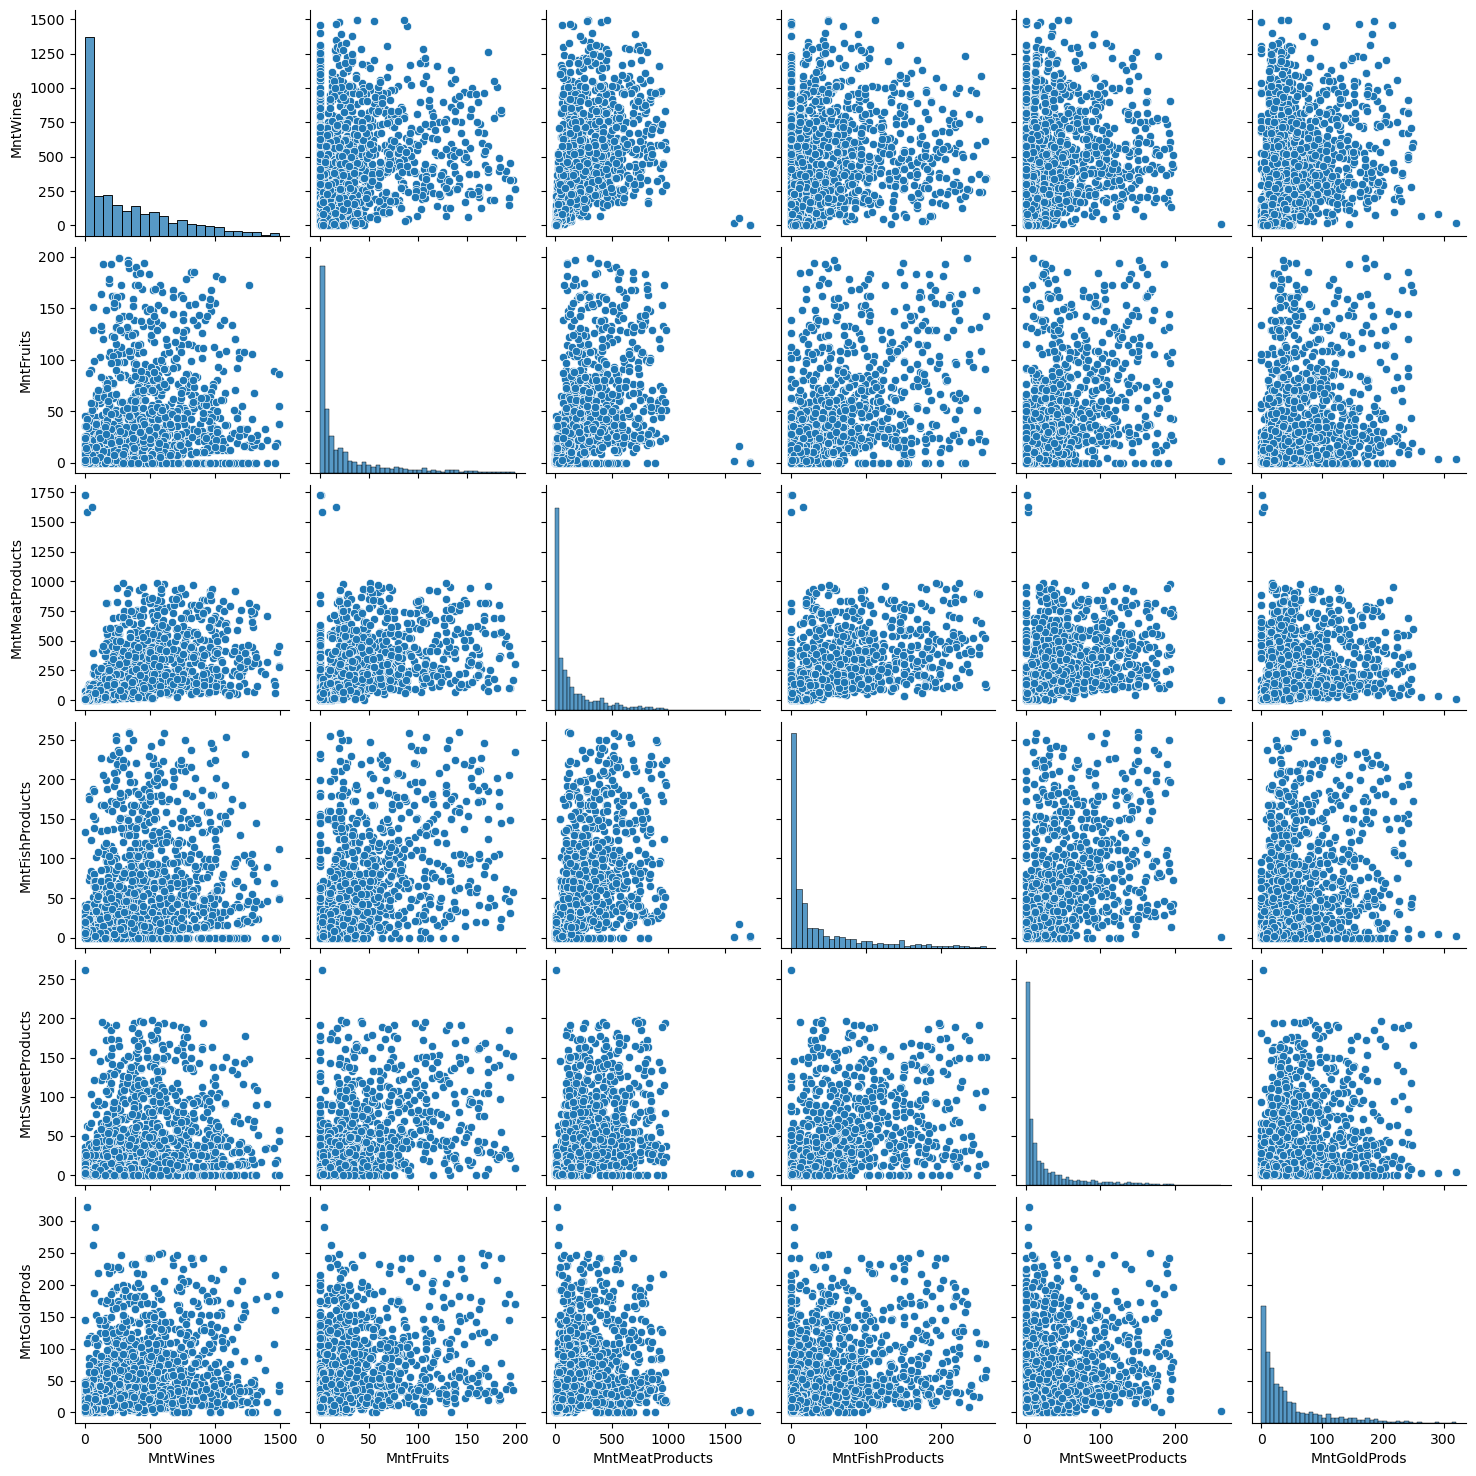

In [20]:
sns.pairplot(products, size=2.5)

All products seems to have a positive correlation. This is common in sales data. Therefore we might be dealing with highly correlated data. We will look at the correlation plot to confirm that.

<Axes: >

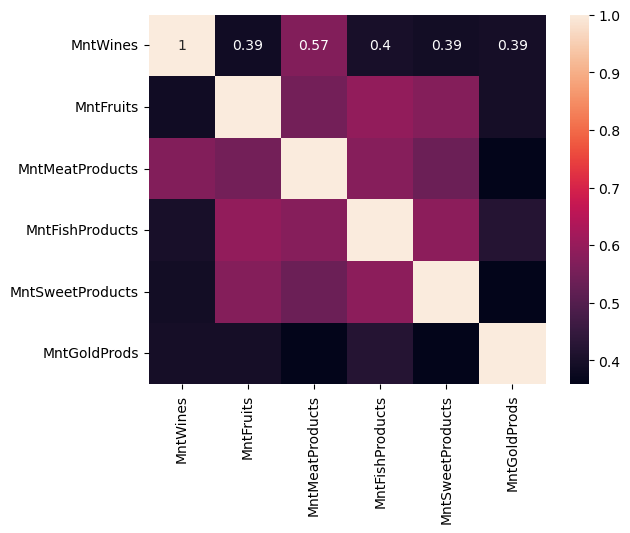

In [21]:
# Correlation plot
corr_matrix = products.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)

We do not notice any high level of correlation (values closer to -1 or 1) but its worth mentioning that Meat and Wines seem to be correlated at 0.57. Despite being moderate, we might want to use PCA analysis to remove collinearity in our entire dataset.

/opt/anaconda3/envs/nlp_hw4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


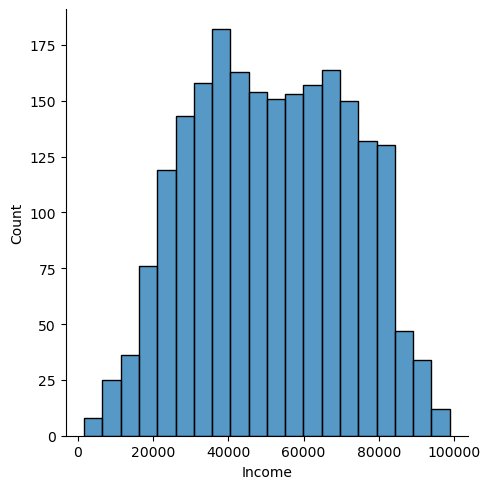

In [22]:
display(sns.displot(cleaned_df, x='Income'))

/opt/anaconda3/envs/nlp_hw4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


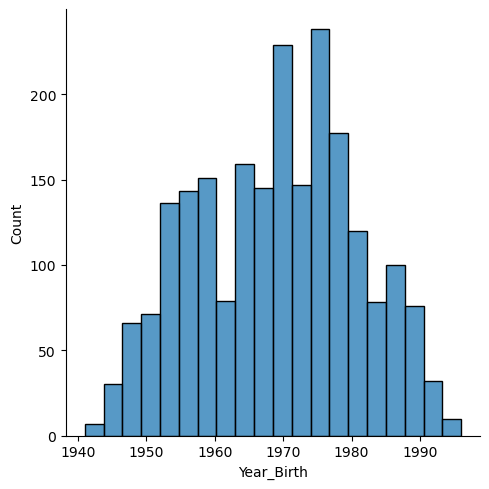

In [23]:
sns.displot(cleaned_df, x='Year_Birth')

/opt/anaconda3/envs/nlp_hw4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


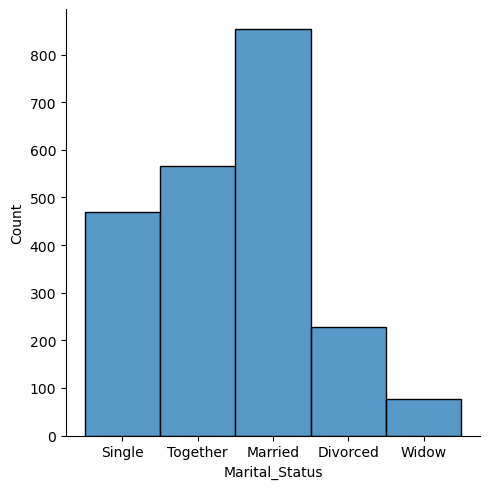

In [24]:
# Marital_Status
sns.displot(cleaned_df, x='Marital_Status')

'Income' and 'Year_Birth' appears to be normally distributed. However, 'Marital_Status' is quite left skewed. In our preprocessing step it will be important to normalize the data to ensure all variables are centered around the mean

## 3. Preprocessing
We have a clean dataset but still a few issues namely Skewness and collinearity. The preprocessing step will consiste of the following:  
1. **one-hot encoding**: K-means features need to be in numeric form. This implies that we will have to encode the features 'Married_Status' and 'Education'. Here, we will use the popular one-hot encoding technique.  
2. **Normalization**: Data should be centered around their mean. Having seen a case of skweness, we will need to normalize our data.   
3. **Principle Component Analysis**: Given the number of features (currently 27, with more expected from one-hot encoding), we might want to apply dimensionality reduction. We will apply PCA to our features before modeling to reduce the effect of collinearity, as observed above, and more importantly, to remove 'noise' from our data. An added benefit is that PCA will help us understand the importance of certain data attributes through feature extraction in the last part of the analysis. 
   
The end goal is to create a vector X that will be fed into our K-means model.


### 3.1 One hot encoding of categorical variables

In [25]:
# One hot encoding for categorical features
features = pd.get_dummies(cleaned_df, columns = ['Marital_Status', 'Education'])
features.shape

(2194, 35)

### 3.2 Data normalization

In [26]:
# Normalizing the date to be centered around the mean
norm_features = (features - features.mean())/features.std()
norm_features = norm_features.astype('float') # Sanity check that all the data are numeric

### 3.3 PCA
PCA will be computed in 3 main steps:
1. Center the data around the mean (already done above!)
2. Decompose our matrix into its principles components
3. Finding the optimal number of features

In [27]:
# converting the normalized features into an np.array as the input for PCA
X = norm_features.to_numpy()
print(X.shape)

(2194, 35)


In [28]:
# Decompose our matrix into its principles components
U, Sigma, VT = np.linalg.svd(X, full_matrices= False)
print('U:', U.shape)
print('Sigma:', Sigma.shape)
print('VT:', VT.shape)

U: (2194, 35)
Sigma: (35,)
VT: (35, 35)


In [29]:
# finding n: optimal number of features
def relative_error(Sigma, n): # compression_error (Sigma, k)
    """
    Returns the error associated with the number of features selected
    Inputs: 
        Sigma: singular values of  X
        n: range of possible number of features
    Outputs:
        error: relative error
    """
    s = Sigma.shape[0]
    not_retained = Sigma[n:] # the bottom of the matrix to be left over. We know Sigma is already sorted
    not_retained_sum = np.sum(not_retained**2)
    norm = np.linalg.norm(Sigma)     # compute the norm
    error = np.sqrt(not_retained_sum) / norm     # calculate the error
    return error
    ###

def best_n(rel_err_target, Sigma):
    '''
    determine the truncation point, k where the relative error just falls below a given target
    Inputs: 
        rel_err_target: relative error target
        Sigma: singular values of  X
    Outputs:
        n: optimal number of features
    '''
    s = Sigma.shape[0]
    for i in range(s-1):
        error = relative_error(Sigma, i)
        if error < rel_err_target:
            print('Relative error target:',round(error, 2))
            return i

# printing n  
rel_err_target = 0.40 # 0.80 --> 4 clusters which is right
n_features = best_n(rel_err_target, Sigma)
retained = round(len(features.columns) - n_features)
# print("Relative error target:", round((rel_err_target), 2))
print("Suggested value of k:", n_features)
print('Proportion of variables retained over total: {} / {}'.format(retained, len(features.columns)))

Relative error target: 0.38
Suggested value of k: 19
Proportion of variables retained over total: 16 / 35


In [30]:
# Truncating our features vector to consider only the number of features suggested above
X = np.dot(U[:, :n_features], np.diag(Sigma[:n_features]))

## 4. Modelling K Means clustering
As a reminder, our goal is to segment customers into meaningful groups to improve campaign targeting for each targeted group. For this purpose, we are using K-means clustering, which is an unsupervised machine learning model. K-means works by randomly assigning each data point to a predefined number of clusters and iteratively minimizing the total inter-cluster distance until convergence using a distance as a similarity measure.  
Our modelling will be executed in 2 steps:
- Finding the right number of clusters using the elbow method
- Modelling the clusters:
    * Initializing the clusters centers
    * Compute the distance matrix
    * Update clusters centers
    * Check for convergence
- Interpretating the results

### 4.1 Finding the right number of clusters

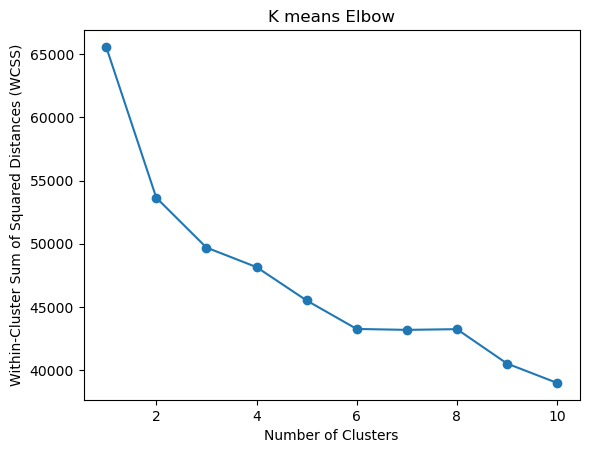

In [31]:
def kmeans(X, k, max_iterations=100):
    '''
    Finding the best value of k using the elbow method
    '''
    # Initialize centroids randomly
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]
    
    for _ in range(max_iterations):
        # Assign each data point to the nearest centroid
        clusters = [[] for _ in range(k)]
        for point in X:
            distances = [np.linalg.norm(point - centroid) for centroid in centroids]
            cluster_index = np.argmin(distances)
            clusters[cluster_index].append(point)
        
        # Update centroids based on the mean of points in each cluster
        new_centroids = np.array([np.mean(cluster, axis=0) for cluster in clusters])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return centroids, clusters

def compute_wcss(X, centroids, clusters):
    wcss = 0
    for centroid, cluster in zip(centroids, clusters):
        wcss += np.sum((np.array(cluster) - centroid) ** 2)
    return wcss

# Set the range of k values to try
k_values = range(1, 11)  # Try k from 1 to 10

# Compute WCSS for each value of k
wcss_values = []
for k in k_values:
    centroids, clusters = kmeans(X, k)
    wcss = compute_wcss(X, centroids, clusters)
    wcss_values.append(wcss)

# Plot the curve
plt.plot(k_values, wcss_values, marker='o')
plt.title('K means Elbow')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squared Distances (WCSS)')
plt.show()

In [32]:
k_target = 3 # suggested value from the elbow graph

### 4.2 Modelling

In [33]:
def init_centers(X, k):
    random.seed(10) # setting a random seed to ensure consistent result every time the code is run
    # this is important because centers are initialized randomly.
    '''
    approach: np.take randomly select indices and extract corresponding rows
    todo
    1. randomly select indices using np.random.choice
    2. take the corresponding rows using np.rake
    '''
    indices = np.random.choice(X.shape[0], size= k, replace= False)
    rows = np.take(X, indices, axis= 0)
    return rows

In [34]:
def kmeans(X, k, starting_centers=init_centers, max_steps=np.inf):
    '''
    Cluster data and return labels
    '''
    # random.seed(10)
    centers = init_centers(X, k)
        
    converged = False # initiating convergence value
    labels = np.zeros(len(X)) # initiating a vector to hold the values of the labels
    i = 1

    # compute the distance
    def compute_d2(X, centers):
        '''
        Create the distance matrix
        '''
        dist_matrix = np.zeros((X.shape[0], centers.shape[0]))

        for i in range(X.shape[0]):
            for j in range(centers.shape[0]):
                dist_matrix[i,j]= np.linalg.norm(X[i] - centers[j])**2
        return dist_matrix
    

    def assign_cluster_labels(S):
        '''
        Assign each point to a cluster
        goal: compare the distance from each point to each cluster center and return the min of them
        inputs: S the distance matrix of shape mxk
        output: a 1D array column vector 
        approach: argmin()
        '''
        indices = np.argmin(S, axis= 1) # column wise

        return indices
    
    def update_centers(X, y):
        m, d = X.shape
        k = max(y) + 1
        assert m == len(y)
        assert (min(y) >= 0)
        centers = np.empty((k, d))
        for j in range(k):
            '''
            inputs: k is the nber of clusters     
            '''
            centers = np.array([X[y == i].mean(axis= 0) for i in range(k)])
        return centers
   

    def has_converged(old_centers, centers):
        '''Check if the model has converge'''
        return set([tuple(x) for x in old_centers]) == set([tuple(x) for x in centers])
    
    while (not converged) and (i <= max_steps):
        old_centers = centers
        S = compute_d2(X, centers)
        labels = assign_cluster_labels(S)
        centers = update_centers(X, labels)
        converge = has_converged(old_centers, centers)
        if converge == True:
            break
        i += 1
        
    
    return labels

In [35]:
# Iterating over each run and using the kmeans function to create the clusters
# Saving the labels values created after each run in a dictionary
clusters_dict = {}
for i in range(5):
    clusters = kmeans(X, k_target)
    clusters_dict[i] = clusters

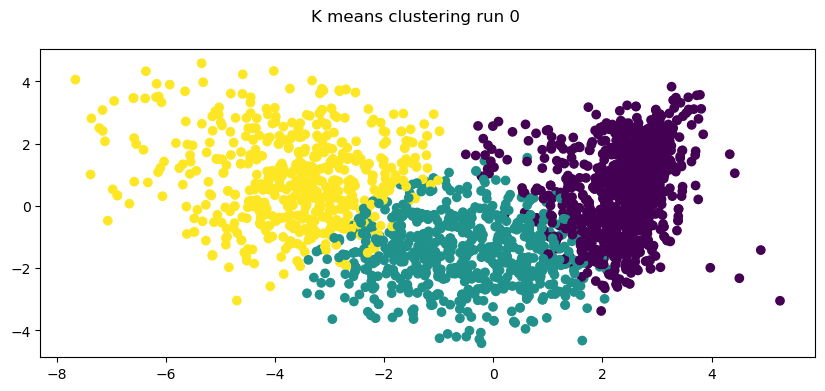

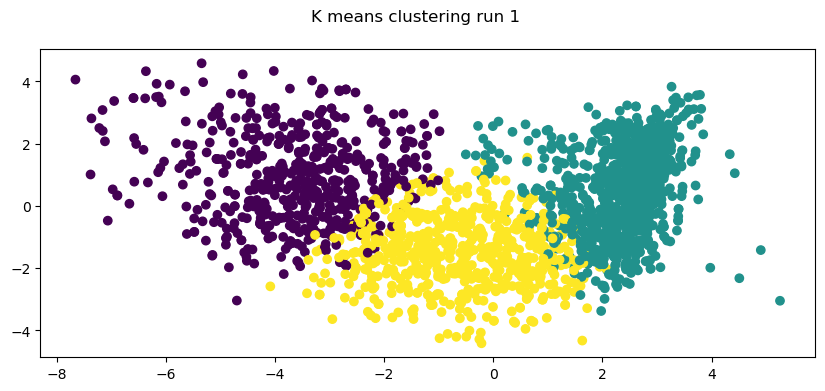

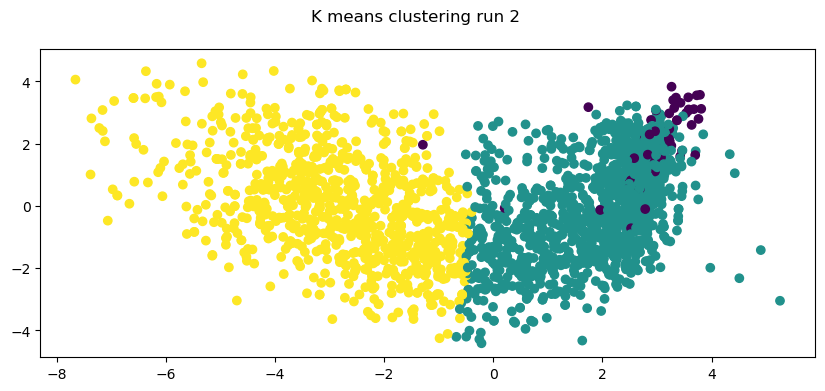

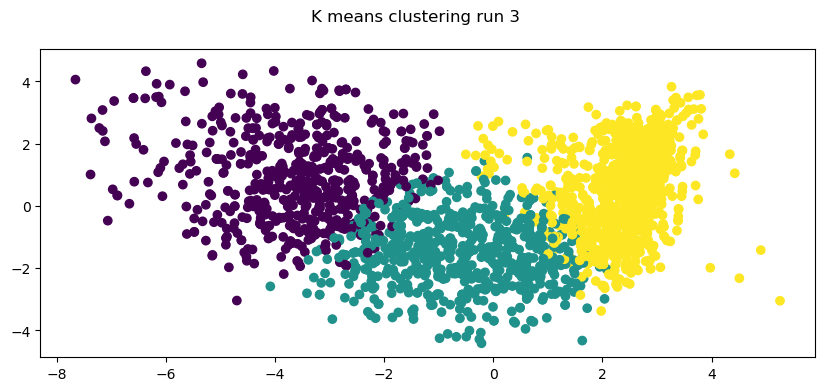

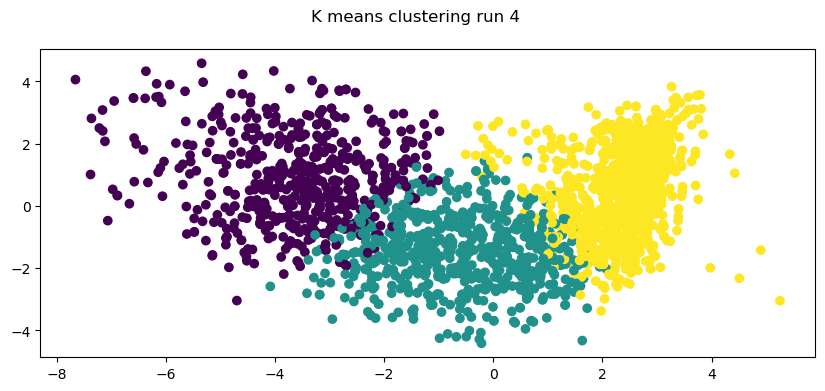

In [36]:
# Displaying the different clusters based on different random initialization of the clusters
for i, val in enumerate(clusters_dict.values()):
    fig, ax = plt.subplots(figsize=(10, 4))
    plt.scatter(x = X[:, 0], y= X[:, 1], c= val)
    fig.suptitle("K means clustering run {}".format(i))
    plt.show()

Note!  

I discovered that it's common for K-means to produce slightly different results with each run due to its sensitivity to initial centroid placement, despite setting a random seed. This behavior is a result of K-means being a heuristic algorithm with the risk of getting stuck at a local minima.

Running K-means multiple times with different initializations and selecting the best result based on some criterion, such as minimizing within-cluster variance or maximizing silhouette score, or visual inspection using a scatter plot  can be helpful for selecting the right model. We will simply rely on visual inspection and select the model that best sepeare the data with minimum overlap. For subsequent analysis, we have saved the best model locally and re-import it (below).

We have documented such findings to ensure reproducibility and transparency in this analysis in a dictionary holding the labels for each run.

https://stackoverflow.com/questions/25921762/changes-of-clustering-results-after-each-time-run-in-python-scikit-learn
Another learning is that if the variation in cluster assignments is very large even after multiple runs with different initializations, it could indeed indicate that K-means may not be the best clustering algorithm for the dataset. In such cases, we might consider exploring other clustering algorithms that are less sensitive to initialization, such as DBSCAN or hierarchical clustering.


#### Saving and re-importing the best model for subsequent analysis

In [37]:
## I used this code to save the optimal version of the clustering locally 
# and will re-import it later for analysis. 

# labels = clusters_dict[4]
# np.save('labels.npy', labels)

In [38]:
# Re- importing the labels to ensure consistency of analysis whenever this notebook is run
labels = np.load('labels.npy')
labeled_df = features.copy()
labeled_df['labels'] = labels

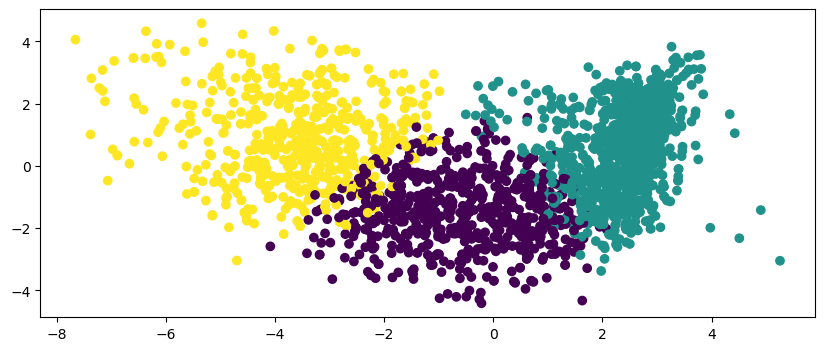

In [39]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(x = X[:, 0], y= X[:, 1], c= labels)

In [40]:
# Renaming the segments
labeled_df['labels'] = labeled_df['labels'].astype('str')
labeled_df.loc[labeled_df['labels'] == '0', 'labels'] = 'segment1'
labeled_df.loc[labeled_df['labels'] == '1', 'labels'] = 'segment2'
labeled_df.loc[labeled_df['labels'] == '2', 'labels'] = 'segment3'

labeled_df.groupby(by= 'labels').size()

labels
segment1    662
segment2    988
segment3    544
dtype: int64

## 5. Analyzing the results
Here we will look at some attributes that seems to better explain the variance in data using PCA from sklearn and also make some recomendations for the company.

### 5.1 What the profile of the ideal customer for the company?

In [41]:
# Fitting the data to the model
pca = PCA(n_components=4)  # We keep the number of components suggested by the PCA.
pca.fit(X)
loadings = pca.components_

# Checking the most important predictors across a sample variables
first_pc_loadings = loadings[0]
max_loading_index = np.argmax(np.abs(first_pc_loadings))
for var in ['Education', 'Marital_Status', 'Income', 'Recency','Kidhome']:   
    most_influential_variable = df[var][max_loading_index]  # Replace with your variable names
    print('In {}, the highest predictor is: {}'.format(var, most_influential_variable))

In Education, the highest predictor is: Graduation
In Marital_Status, the highest predictor is: Single
In Income, the highest predictor is: 58138.0
In Recency, the highest predictor is: 58
In Kidhome, the highest predictor is: 0


Single Graduates with no kids seems to be the ideal customer profile for this company. Their efforts should be focused on understanding the needs of these groups and focusing their marketing efforts in engaging with them. 

### 5.2 Which segment is more likely to engage with future campaigns?

In [42]:
# proportion of customers likely to accept future campaigns having engaged with the last campaign

accepted = round(labeled_df.groupby(by= ['labels'], as_index= False)[['AcceptedCmp_last']].mean(), 2)
accepted

,labels,AcceptedCmp_last
0,segment1,0.11
1,segment2,0.10
2,segment3,0.30


Segment3 customers are more likely to accept future campaigns. The company is therefore doing a great job at targeting them. However, they should review their marketing approach for the others segments to better resonate with their behavior and preferences.

### 5.3 What right channel to display offers for different segments?

In [43]:
channels = round(labeled_df.groupby(by= 'labels')[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].mean(), 2)
total = channels['NumWebPurchases']+ channels['NumCatalogPurchases'] + channels['NumStorePurchases']

cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
for col in cols:
    channels[col] = round(channels[col]/total*100, 2)
channels

,NumWebPurchases,NumCatalogPurchases,NumStorePurchases
labels,,,
segment1,36.35,18.20,45.45
segment2,36.50,9.17,54.33
segment3,26.60,30.24,43.16


It appears that both stores and the web are relevant channels across all customer segments, indicating their importance in the overall marketing strategy. However, the catalog channel seems to be less relevant for segment2.

Based on this insight, it would be beneficial for the company to adjust its campaign execution channels accordingly. This might involve reallocating resources from the catalog channel towards channels that are more effective. By doing so, the company can optimize its marketing efforts and better target its customer segments, potentially leading to improved engagement and sales.

## 6. Summary

This notebook has provided a valuable opportunity to put into practice the concepts learned througout this semester, specifically from notebooks 14 and 15. By applying these concepts to a realistic dataset, we were able to derive meaningful segmentation and generate insights that could be beneficial for a real consumer goods company. Personally, the biggest takeout is ability to cluster customers using a machine learning which is a valuable skill in my industry.   
  
From a learning point of view, running into the issue of clusters initialization has strenghten my understanding of what is happening under the hood of K Means.

Future analysis might involved the use of Hierachical clustering which can help the company deep dive into each group and understand how to further personalize their offers to each sub-group of customers.